# Human Patch seq data mapping alpha and beta cells

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.5 umap==0.4.5 numpy==1.19.4 scipy==1.5.4 pandas==1.1.4 scikit-learn==0.22 statsmodels==0.10.1 python-igraph==0.8.0 louvain==0.7.0 leidenalg==0.7.0


In [3]:
sc.set_figure_params(frameon=False, dpi_save=300, color_map='Reds')

In [4]:
sc.settings.figdir='./figures/'

## Load data and preprocess data

### Patch-Seq

preprocessing as described in paper and provided in source code. Data downloaded from: https://github.com/jcamunas/patchseq/tree/master/data

In [6]:
dict_phenotype_norm = {'CellSize_pF': 'Cell size',
                   'NormalizedTotalCapacitance_fF/pF': 'Total exocytosis',
                   'NormalizedFirstDepolarizationCapacitance_fF/pF': 'Early exocytosis',
                   'NormalizedLateDepolarizationCapacitance': 'Late exocytosis',
                 'CalciumIntegralNormalizedtoCellSize_pC/pF': 'Ca2+ entry',
                   'CapacitanceNormalizedtoCalcium_fF/pC': 'Exocytosis norm Ca2+',
                   'NormalizedEarlyPeakCalciumCurrentAmplitude_pA/pF': 'Early Ca2+ current',
                 'NormalizedLateCalciumCurrentAmplitude_pA/pF': 'Late Ca2+ current',
                   'NormalizedLateCalciumChannelConductance_pS/pF' : 'Late Ca2+ Conductance',
                   'ReversalPotentialbyramp_mV': 'Reversal potential',
                   'NormalizedPeakSodiumCurrentAmplitude_pA/pF': 'Peak Na+ current',
                  'NormalizedSodiumChannelConductance_pS/pF': 'Na+ conductance'}

phenotype_norm = ['Cell size', 'Total exocytosis','Early exocytosis','Late exocytosis',
                          'Ca2+ entry','Exocytosis norm Ca2+', 'Early Ca2+ current','Late Ca2+ current',
                          'Late Ca2+ Conductance','Reversal potential','Peak Na+ current','Na+ conductance']

In [7]:
#Load and reformat patch-seq dataset
filename =  './data/patchclamp_wcryo_human.counts.tab'
metadata = './data/patchclamp_wcryo_human.metadata.tab.txt'

test = pd.read_csv(filename,sep='\t')
annotation = pd.read_csv(metadata,'\t')
annotation = annotation.drop(['cell_type'],axis=1)

annotation['DiabetesStatus'].replace({'heathy': 'healthy'}, inplace=True)
annotation['DiabetesStatus'].replace({'elevated HbA1c': 'T2D'}, inplace=True)
#add cell type information already computed
ct_all = pd.read_csv('./data/cell_typing_merged.csv', sep='\t', index_col=0, names=['cell_type'])
ct_FACS = pd.read_csv('./data/cell_typing_FACS_endocrine.csv', sep='\t', index_col=0, names=['cell_type'])
ct_all = pd.concat([ct_all, ct_FACS])
annotation = annotation.join(ct_all['cell_type'], on='name')
annotation.rename(columns=dict_phenotype_norm, inplace=True)

#remove commas from data ephys
annotation[phenotype_norm] = annotation[phenotype_norm].apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',',''), errors='coerce'))
annotation[phenotype_norm] = annotation[phenotype_norm].astype(float)

In [8]:
#remove genes not seen in 5 cells or having 10 counts total
adata = sc.AnnData(test.T)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.filter_genes(adata, min_counts=10)
adata.obs = annotation.loc[adata.obs_names]

filtered out 11136 genes that are detected in less than 5 cells
filtered out 314 genes that are detected in less than 10 counts


In [9]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [562]:
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

## Beta cell mapping

### Gene set representation

In [5]:
adata_beta = sc.read('./data/adata_human_beta.h5ad')

In [10]:
adata_beta_patch = adata[adata.obs.cell_type.isin(['beta'])].copy()

In [11]:
genes_overlap = list(set(adata_beta.var_names).intersection(adata_beta_patch.var_names))

In [12]:
len(genes_overlap)

15864

subset gene sets to overlapping genes

In [13]:
mk_human = pd.read_excel('./output_files/gene_sets_beta.xlsx')
mk_human_map = {}
for col in mk_human.columns:
    mk_human_map[col] = [gene for gene in mk_human[col] if gene in genes_overlap]

gene set scoring

In [15]:
sc.settings.verbosity=1
for key in mk_human_map.keys():
    sc.tl.score_genes(adata_beta, gene_list=[gene for gene in mk_human_map[key] if gene in adata_beta.var_names], score_name=f'human_G{key}')
    sc.tl.score_genes(adata_beta_patch, gene_list=[gene for gene in mk_human_map[key] if gene in adata_beta_patch.var_names], score_name=f'human_G{key}')

gene set representation

In [16]:
# sorted gene sets
obs_g = ['_'.join(['human',a]) for a in ['G7', 'G8', 'G10', 'G11','G3', 'G17', 'G1', 'G2', 'G5', 'G6', 'G4', 'G12', 'G13', 'G14', 'G18', 'G19', 'G9', 'G16']]

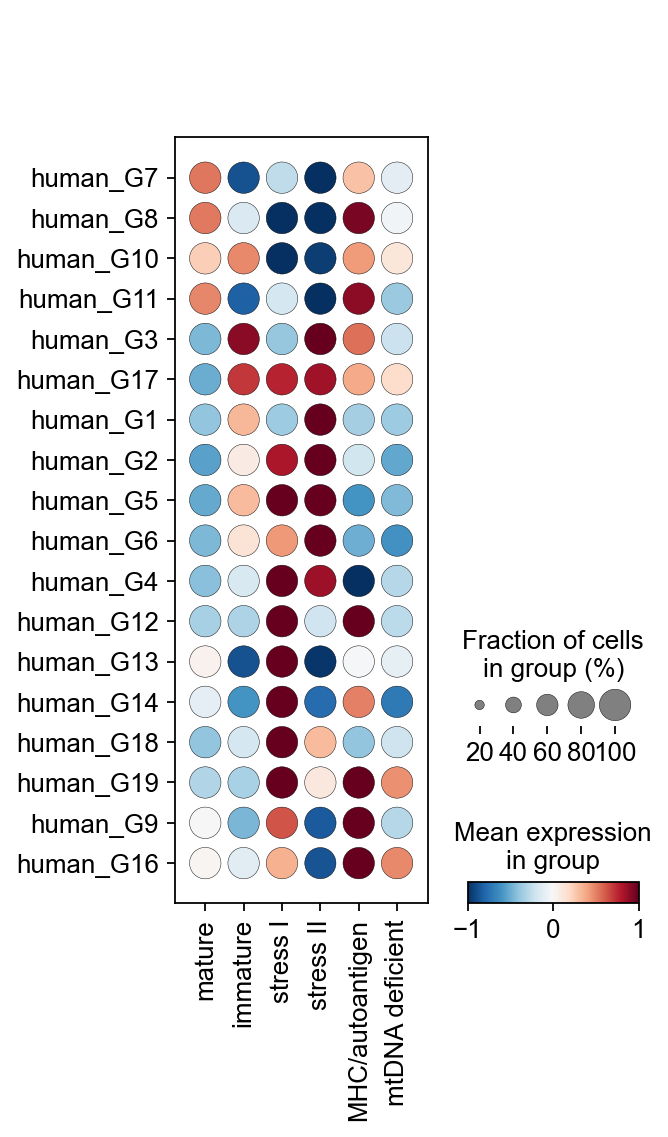

In [17]:
adata_beta_g = sc.AnnData(adata_beta.obs[obs_g])
adata_beta_g.obs = adata_beta.obs
sc.pl.dotplot(sc.pp.scale(adata_beta_g, copy=True), groupby='louvain_anno_fine', 
              var_names=adata_beta_g.var_names, swap_axes=True,  
              expression_cutoff=-3, vmax=1, vmin=-1, cmap='RdBu_r')

In [18]:
adata_beta_patch_g = sc.AnnData(adata_beta_patch.obs[obs_g])
adata_beta_patch_g.obs = adata_beta_patch.obs

### Mapping in gene set space

In [19]:
adata_beta_g_scaled = sc.pp.scale(adata_beta_g, copy=True)
adata_beta_patch_g_scaled = sc.pp.scale(adata_beta_patch_g, copy=True)

In [20]:
adata_beta_g_scaled.uns['louvain_anno_fine_colors']=['#fdb462', '#80b1d3', '#b3de69', '#bebada', '#fb8072', '#8dd3c7']
adata_beta_patch_g_scaled.uns['louvain_anno_fine_colors'] = ['#fdb462', '#80b1d3', '#b3de69', '#bebada', '#fb8072', '#b15928']

compute reference embedding

In [21]:
sc.pp.pca(adata_beta_g_scaled)
sc.pp.neighbors(adata_beta_g_scaled)
sc.tl.umap(adata_beta_g_scaled)

/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


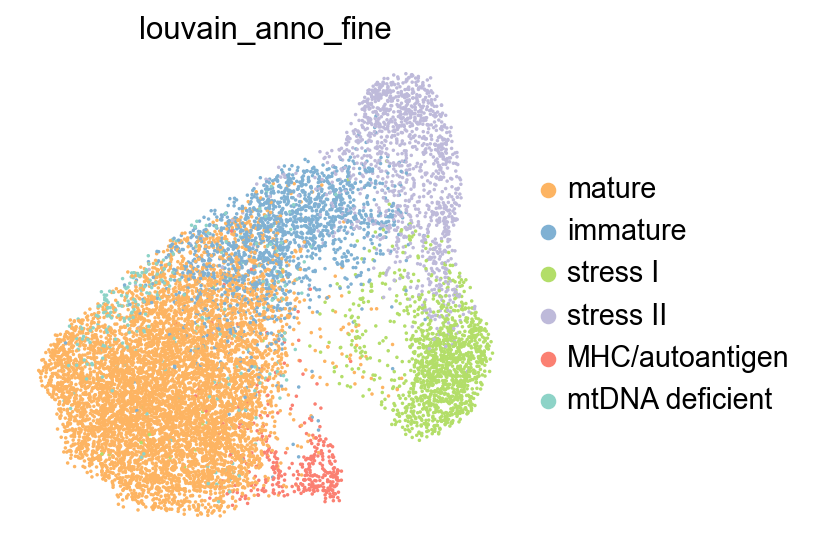

In [22]:
sc.set_figure_params(frameon=False)
sc.pl.umap(adata_beta_g_scaled, color='louvain_anno_fine')

map patch-seq data to reference

In [23]:
sc.tl.ingest(adata_beta_patch_g_scaled, adata_beta_g_scaled , obs='louvain_anno_fine', neighbors_key='neighbors')

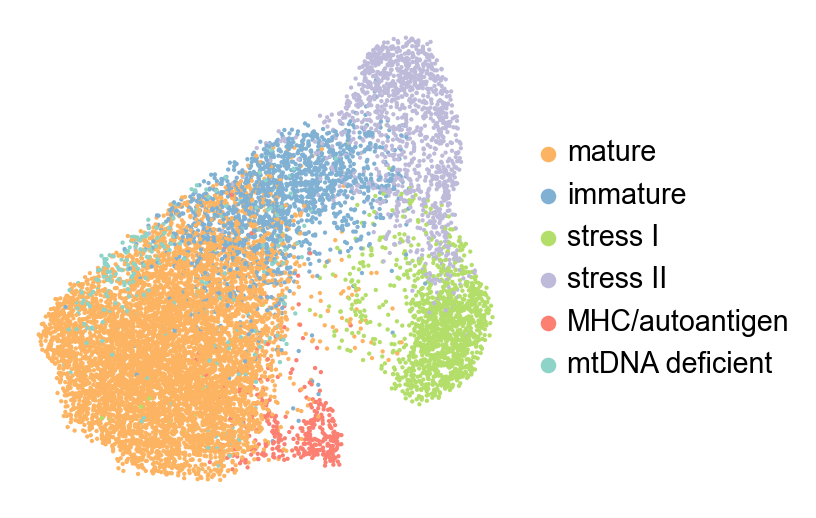

... storing 'project' as categorical
... storing 'sequencingInstrument' as categorical
... storing 'sequencingRun' as categorical
... storing 'sequencingDate' as categorical
... storing 'species' as categorical
... storing 'CellTypeEstimatePatching' as categorical
... storing 'SodiumChannelConductance_pS' as categorical
... storing 'SolutioninDish' as categorical
... storing 'gene_group_NUP93' as categorical
... storing 'preincubation' as categorical
... storing 'Patched' as categorical
... storing 'DonorID' as categorical
... storing 'Cryopreserved' as categorical
... storing 'DiabetesStatus' as categorical
... storing 'FACS sorted' as categorical
... storing 'Sex' as categorical
... storing 'Donation type' as categorical
... storing 'DNA content (ug):' as categorical
... storing '10 mM to 1 mM stimulation index' as categorical
... storing '16.7 mM to 1 mM stimulation index' as categorical
... storing '16.7 mM to 2.8 mM stimulation index' as categorical
... storing 'notes' as categori

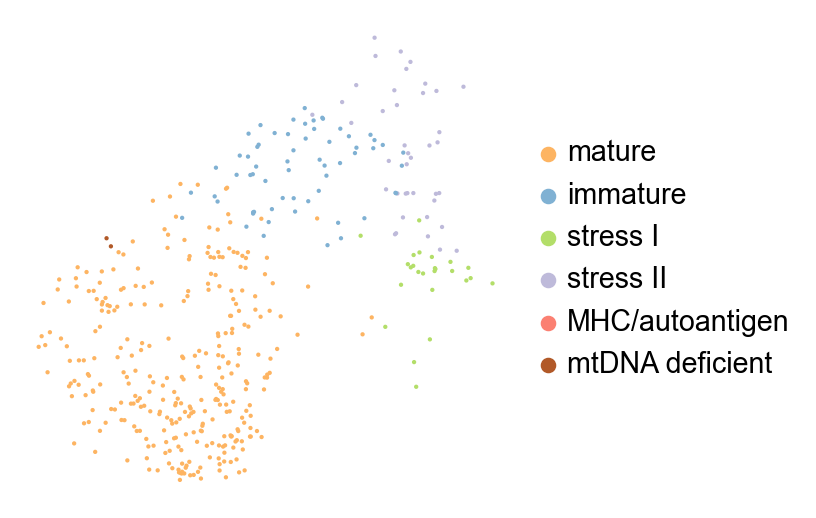

In [24]:
sc.pl.umap(adata_beta_g_scaled, color='louvain_anno_fine', size=15, title='')
sc.pl.umap(adata_beta_patch_g_scaled, color=['louvain_anno_fine'], size=15, title='')

In [25]:
adata_beta_patch_g_scaled.obs.louvain_anno_fine.value_counts()

mature             310
immature            62
stress II           40
stress I            25
mtDNA deficient      2
MHC/autoantigen      0
Name: louvain_anno_fine, dtype: int64

transfer labels to expression data

In [26]:
adata_beta_patch = adata[adata.obs.cell_type.isin(['beta'])].copy()

In [27]:
adata_beta_patch.obs['louvain_anno_fine'] = adata_beta_patch_g_scaled.obs['louvain_anno_fine']

In [28]:
pd.crosstab(adata_beta_patch.obs.louvain_anno_fine, adata_beta_patch.obs.DiabetesStatus)

DiabetesStatus,T2D,T2Dreversed,cryo_T1D,cryo_healthy,healthy,prediabetic
louvain_anno_fine,,,,,,
mature,73,2,11,38,171,15
immature,10,3,1,14,34,0
stress I,2,0,0,1,19,3
stress II,17,0,0,8,13,2
mtDNA deficient,0,0,0,2,0,0


subset to louvain-clusters with > 2 cells, and healthy and patched cells

In [29]:
adata_beta_patch = adata_beta_patch[np.invert(adata_beta_patch.obs.louvain_anno_fine.isin(['mtDNA deficient']))].copy()

In [30]:
adata_beta_patch = adata_beta_patch[adata_beta_patch.obs.DiabetesStatus.isin(['healthy', 'cryo_healthy'])].copy()

In [31]:
adata_beta_patch = adata_beta_patch[adata_beta_patch.obs.Patched=='Yes'].copy()

In [32]:
pd.crosstab(adata_beta_patch.obs.louvain_anno_fine, adata_beta_patch.obs.DonorID)

DonorID,R229,R230,R232,R233,R234,R235,R237,R238,R239,R242,R243,R246,R247,R252,R253,R256,R260,R264,cryo_R134,cryo_R177
louvain_anno_fine,,,,,,,,,,,,,,,,,,,,
mature,6,6,2,11,11,29,10,1,14,0,6,3,3,14,5,10,11,7,32,5
immature,1,0,0,5,1,3,0,5,0,1,3,0,0,1,1,0,1,1,11,1
stress I,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
stress II,0,0,0,3,0,0,0,0,1,1,0,0,0,0,0,0,0,0,4,0


In [33]:
adata_beta_patch.obs.louvain_anno_fine.value_counts()

mature       186
immature      35
stress II      9
stress I       3
Name: louvain_anno_fine, dtype: int64

### Gene set activation

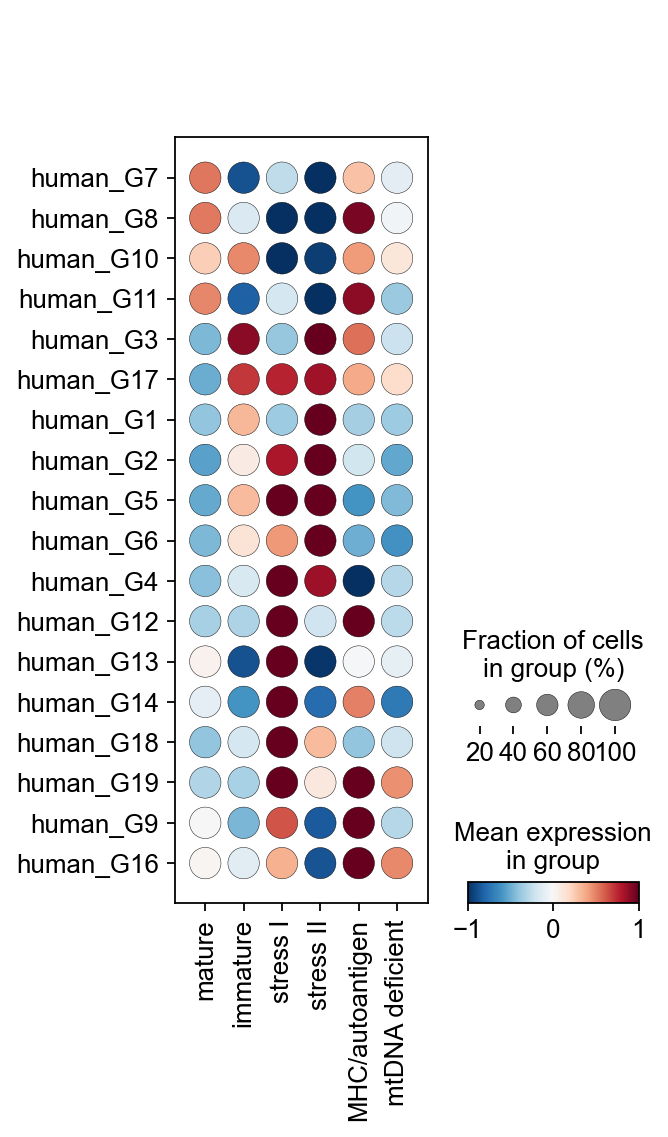

In [57]:
sc.pl.dotplot(adata_beta_g_scaled, groupby='louvain_anno_fine', 
              var_names=adata_beta_g.var_names, swap_axes=True,  
              expression_cutoff=-3, vmax=1, vmin=-1, cmap='RdBu_r')

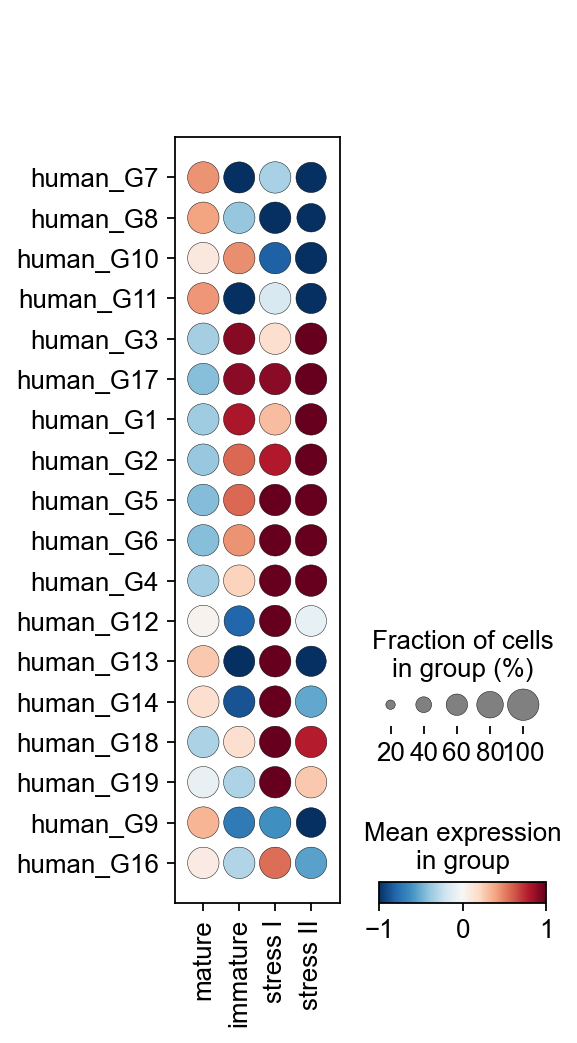

In [60]:
sc.pl.dotplot(adata_beta_patch_g_scaled[~adata_beta_patch_g_scaled.obs.louvain_anno_fine.isin(['mtDNA deficient'])].copy(), groupby='louvain_anno_fine', 
              var_names=adata_beta_g.var_names, swap_axes=True,  
              expression_cutoff=-3, vmax=1, vmin=-1, cmap='RdBu_r')

### Cell state distribution

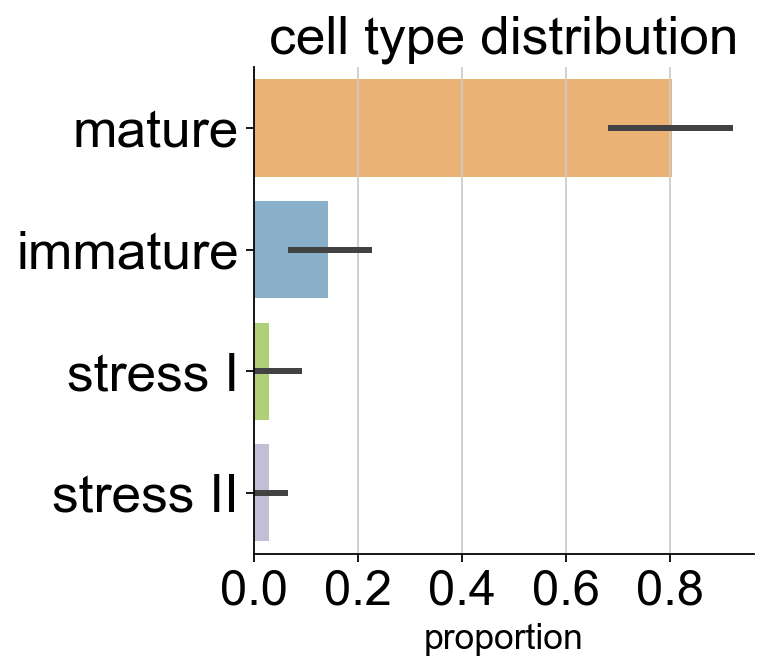

In [34]:
x='louvain_anno_fine'
hue='DonorID'
y='proportion'

df = pd.crosstab(adata_beta_patch.obs[x], adata_beta_patch.obs[hue], normalize=1)

df.index = df.index.tolist()
df.columns = df.columns.tolist()
prop_df = df.reset_index().melt(id_vars=['index'])

sns.barplot(y='index', x='value', data=prop_df, palette=adata_beta.uns['louvain_anno_fine_colors'], orient='h')
pl.xticks(rotation=0,fontsize=22)
pl.yticks(rotation=0,fontsize=24)

pl.title('cell type distribution', fontsize=24)
pl.ylabel('')
pl.xlabel('proportion',fontsize=16)
sns.despine()
pl.show()

In [35]:
x1='louvain_anno_fine'
hue='DonorID'
y='proportion'
df = pd.crosstab(adata_beta_patch.obs[x1], adata_beta_patch.obs[hue], normalize=1)
df.index = df.index.tolist()
df.columns = df.columns.tolist()
prop_df = df.reset_index().melt(id_vars=['index'])

In [38]:
adata_beta_patch.obs.louvain_anno_fine.value_counts(normalize=True)

mature       0.798283
immature     0.150215
stress II    0.038627
stress I     0.012876
Name: louvain_anno_fine, dtype: float64

### Electrophysiology

processing and filering steps adapted as described in original manuscript and copied from source code

In [39]:
adata_beta_patch = adata_beta_patch[np.invert(adata_beta_patch.obs.louvain_anno_fine.isin(['stress I']))].copy()

In [40]:
def filter_quantile_values(df, columns=None, qlow=0.1,qhigh=0.9, include_quantiles=True):
    '''takes dataframe df and for all the columns adds Nan to values above or below extreme quantiles
    df: dataframe to filter
    qlow: minimum quantilie
    qhigh: maximum quantile
    columns: do filtering in subset of columns
    include_quantiles: whether qlow and qhigh are included in the filtered dataset or removed
    (important for skewed distributions, with lots of zweros for instance)'''

    df1 = df.copy()
    s =df1
    if columns:
        s = df1[columns]

    if include_quantiles is True:
        s = s[s<=s.quantile(qhigh)]
        s = s[s>=s.quantile(qlow)]
    else:
        s = s[s<s.quantile(qhigh)]
        s = s[s>s.quantile(qlow)]

    df1[columns] = s

    return df1

In [41]:
ephys_dict= {'Size': ['Cell size'],
         'Exocytosis': ['Total exocytosis','Early exocytosis','Late exocytosis'],
         'Sodium channels'  : ['Peak Na+ current','Na+ conductance'],
         'Calcium channels': ['Ca2+ entry','Early Ca2+ current','Late Ca2+ current','Late Ca2+ Conductance'],
         }
ephys_list = []
for key, par in ephys_dict.items():
    ephys_list = ephys_list + par

In [42]:
df_meta = adata_beta_patch.obs[ephys_list].copy()

In [43]:
df_meta = df_meta.loc[adata_beta_patch.obs.Patched=='Yes'].copy()

In [44]:
df_meta.dropna(axis=0, how='all', inplace=True)

In [45]:
qlow=0.03
qhigh=0.97
x = filter_quantile_values(df_meta, columns=ephys_list, qlow=qlow, qhigh=qhigh, include_quantiles=False)

In [46]:
df_meta.fillna(0, inplace=True)

In [47]:
x['cell_type'] = adata_beta_patch.obs.loc[x.index, 'louvain_anno_fine']

In [48]:
x.cell_type.value_counts()

mature       186
immature      35
stress II      9
Name: cell_type, dtype: int64

In [49]:
def df_get_mu_pvals(df, pars, column_class='cell_type', categories=['mature', 'immature']):
    from scipy.stats import mannwhitneyu
    from scipy.stats import ks_2samp
    from statsmodels.stats.multitest import multipletests
    pvals ={}
    for par in pars:
        cond1= df[column_class]==categories[0]
        group1 = df[cond1][par].dropna()
        cond2= df[column_class]==categories[1]
        group2 = df[cond2][par].dropna()
        pvals[par] = mannwhitneyu(group1, group2, use_continuity=True, alternative=None)[1]

        pvals =pd.Series(pvals)
    pvals = pd.DataFrame(pvals,columns=['pval'])
    pvals['FDR'] = multipletests(pvals['pval'], method='fdr_bh')[1]
    return pvals

In [50]:
for par in ephys_list:
    if x[par].mean() < 0:
        x[par] = -1*(x[par])
    #clip value of electrophysiology to zero, no negative values
    x[par] = x[par].clip(lower=0)


In [51]:
pvals = df_get_mu_pvals(x, pars=ephys_list[1:], categories=['mature', 'immature'])

In [52]:
pvals

,pval,FDR
Total exocytosis,0.073398,0.153635
Early exocytosis,0.017232,0.051696
Late exocytosis,0.099037,0.153635
Peak Na+ current,0.000604,0.005433
Na+ conductance,0.010626,0.047817
Ca2+ entry,0.160132,0.205884
Early Ca2+ current,0.102423,0.153635
Late Ca2+ current,0.433043,0.433043
Late Ca2+ Conductance,0.415305,0.433043


In [53]:
pvals_2 = df_get_mu_pvals(x, pars=ephys_list[1:], categories=['mature', 'stress II'])
pvals_2

,pval,FDR
Total exocytosis,0.016501,0.066548
Early exocytosis,0.025322,0.066548
Late exocytosis,0.020852,0.066548
Peak Na+ current,0.209197,0.300981
Na+ conductance,0.400227,0.400227
Ca2+ entry,0.234096,0.300981
Early Ca2+ current,0.029577,0.066548
Late Ca2+ current,0.109839,0.197711
Late Ca2+ Conductance,0.296009,0.333010


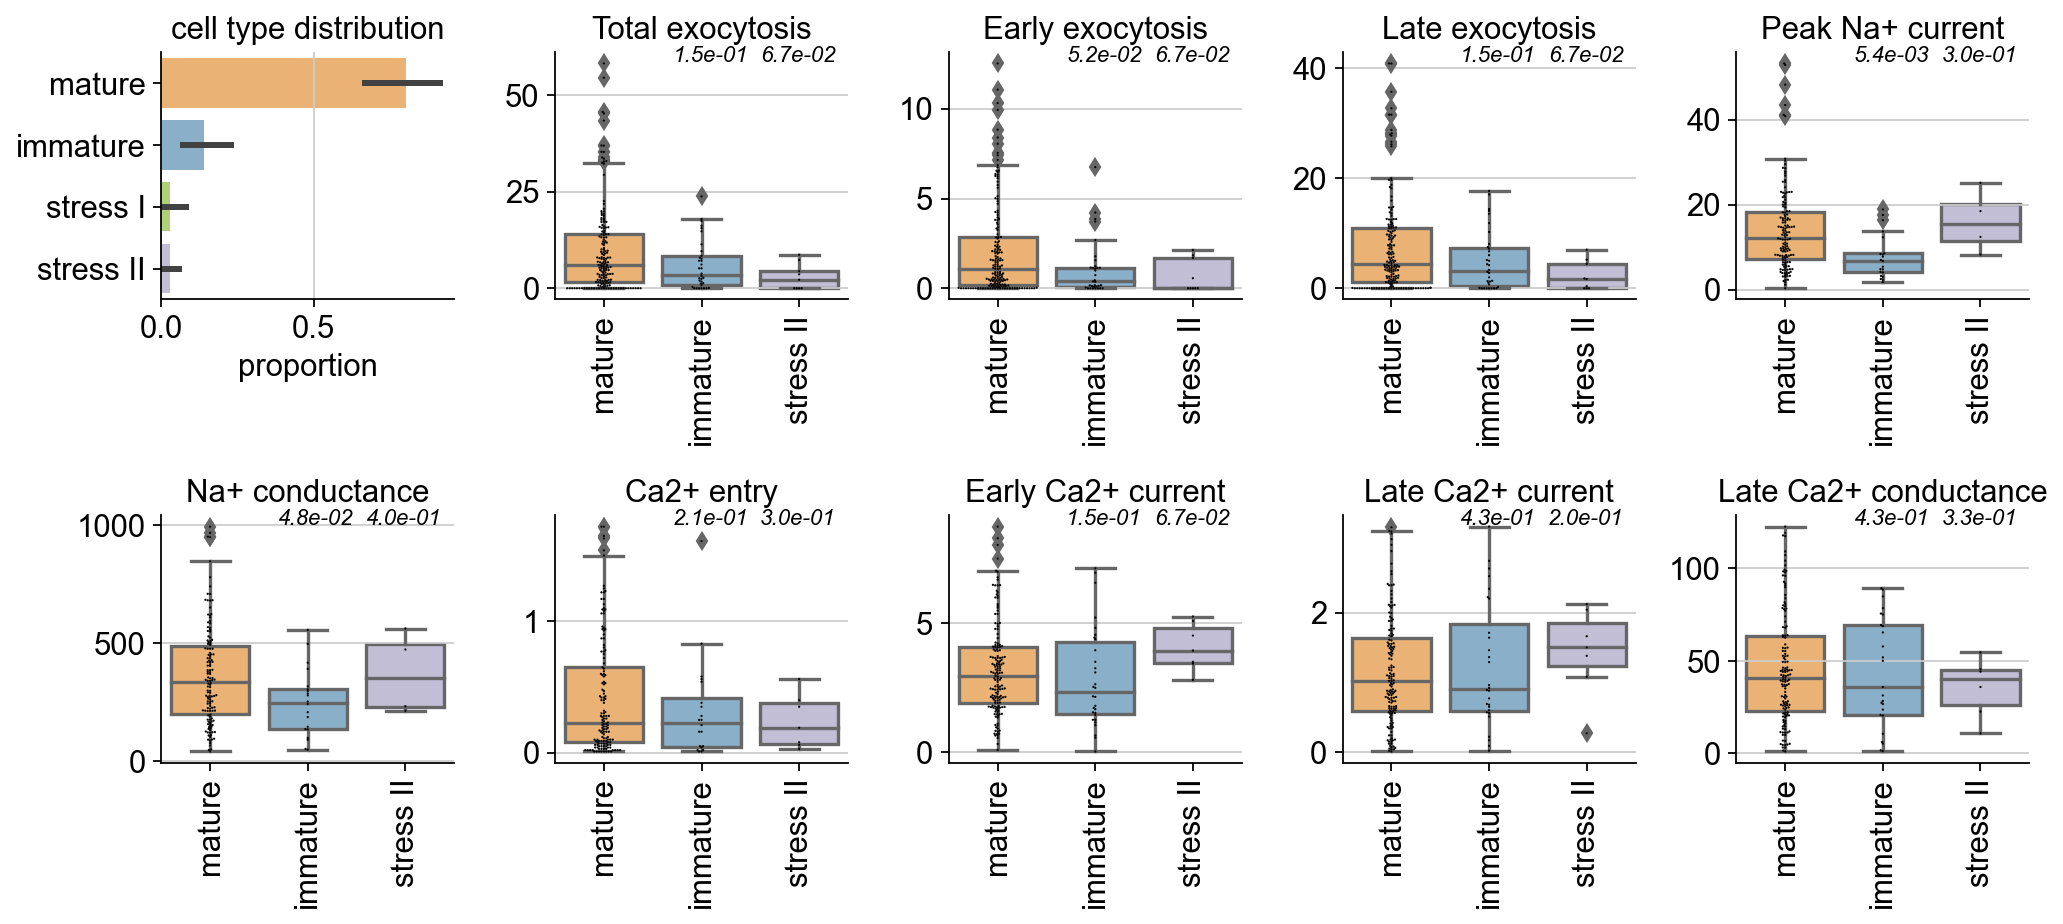

In [64]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(13,6))
axs = axs.flatten()




sns.barplot(y='index', x='value', data=prop_df, palette=adata_beta.uns['louvain_anno_fine_colors'], orient='h', ax=axs[0])

axs[0].set_title('cell type distribution')
axs[0].set_xlabel('proportion')
axs[0].set_ylabel('')




for j, key in enumerate(ephys_list[1:]):
    i = j+1
    sns.boxplot(data=x, y=key, x='cell_type', ax=axs[i], palette=['#fdb462', '#80b1d3', '#bebada'])
    sns.swarmplot(data=x, y=key, x='cell_type', ax=axs[i], size=1, palette=['black'])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    #axs[i].text(0.5,0.96, r'$p_{{FDR}}=${:.1e}'.format(pvals.loc[key,'FDR']), style='italic',fontsize=10, transform = axs[i].transAxes)
    
    axs[i].text(0.4,0.96, r'{:.1e}'.format(pvals.loc[key,'FDR']), style='italic',fontsize=10, transform = axs[i].transAxes)
    axs[i].text(0.7,0.96, r'{:.1e}'.format(pvals_2.loc[key,'FDR']), style='italic',fontsize=10, transform = axs[i].transAxes)

    axs[i].set_title(key)
#     if key =='Total Exocitosis':
#         axs[i].set_title('Total exocytosis')
    if key =='Late Ca2+ Conductance':
        axs[i].set_title('Late Ca2+ conductance')

    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    
sns.despine()
plt.tight_layout()
plt.show()

## Alpha cells

### Gene set representation

In [65]:
adata_alpha = sc.read('./data/adata_human_alpha.h5ad')

In [66]:
adata_alpha_patch = adata[adata.obs.cell_type.isin(['alpha'])].copy()

In [67]:
genes_overlap = list(set(adata_alpha.var_names).intersection(adata_alpha_patch.var_names))

In [68]:
len(genes_overlap)

15287

In [69]:
mk_human = pd.read_excel('./output_files/gene_sets_alpha.xlsx')
mk_human_map = {}
for col in mk_human.columns:
    mk_human_map[col] = [gene for gene in mk_human[col] if gene in genes_overlap]

In [70]:
sc.settings.verbosity=1
for key in mk_human_map.keys():
    sc.tl.score_genes(adata_alpha, gene_list=[gene for gene in mk_human_map[key] if gene in adata_alpha.var_names], score_name=f'human_G{key}')
    sc.tl.score_genes(adata_alpha_patch, gene_list=[gene for gene in mk_human_map[key] if gene in adata_alpha_patch.var_names], score_name=f'human_G{key}')

In [71]:
sc.set_figure_params()

In [72]:
# sorted gene sets
obs_g = ['_'.join(['human',a]) for a in ['G7', 'G8', 'G12', 'G13', 'G3', 'G4', 'G2', 'G5', 'G1', 'G6', 'G14', 'G10']]

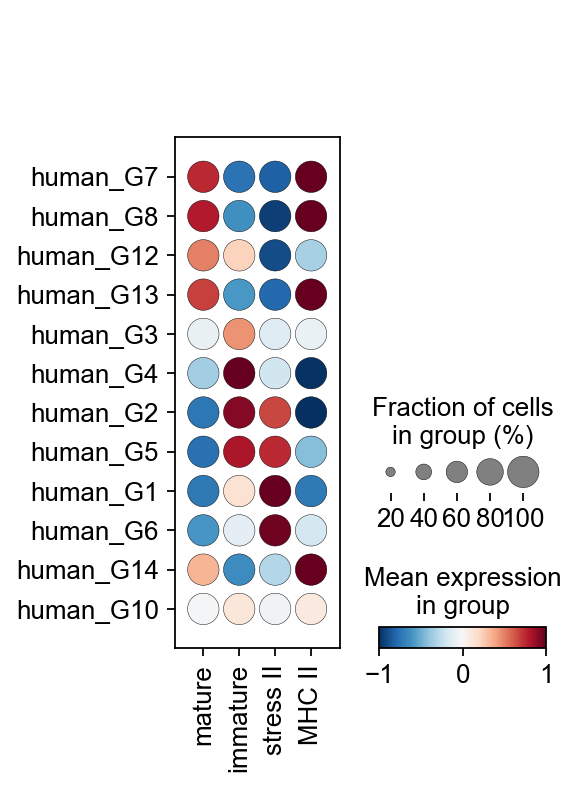

In [73]:
adata_alpha_g = sc.AnnData(adata_alpha.obs[obs_g])
adata_alpha_g.obs = adata_alpha.obs
sc.pl.dotplot(sc.pp.scale(adata_alpha_g, copy=True), groupby='louvain_anno_fine', 
              var_names=adata_alpha_g.var_names, swap_axes=True,  
              expression_cutoff=-3, vmax=1, vmin=-1, cmap='RdBu_r')

In [74]:
adata_alpha_patch_g = sc.AnnData(adata_alpha_patch.obs[obs_g])
adata_alpha_patch_g.obs = adata_alpha_patch.obs

### Mapping in gene set space

In [75]:
adata_alpha_g_scaled = sc.pp.scale(adata_alpha_g, copy=True)
adata_alpha_patch_g_scaled = sc.pp.scale(adata_alpha_patch_g, copy=True)

In [76]:
adata_alpha_g_scaled.uns['louvain_anno_fine_colors']=['#fdb462', '#80b1d3', '#bebada', '#fb8072', '#8dd3c7']
adata_alpha_patch_g_scaled.uns['louvain_anno_fine_colors'] = ['#fdb462', '#80b1d3', '#bebada', '#fb8072', '#b15928']

compute reference embedding

In [77]:
sc.pp.pca(adata_alpha_g_scaled)
sc.pp.neighbors(adata_alpha_g_scaled)
sc.tl.umap(adata_alpha_g_scaled)

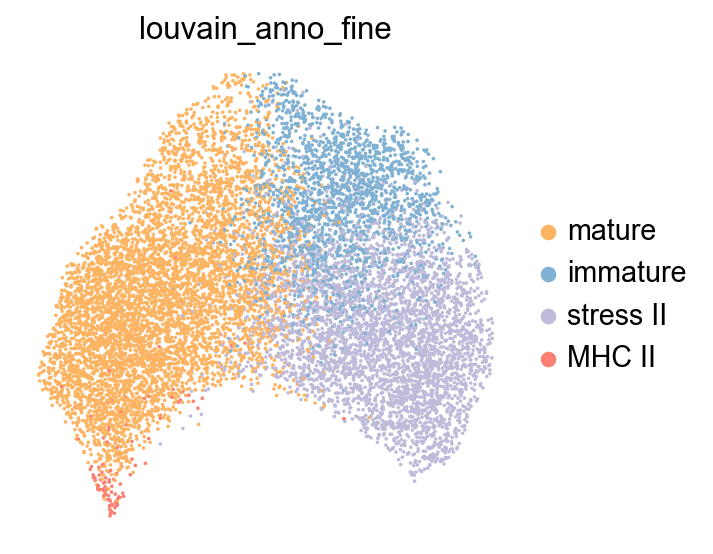

In [78]:
sc.set_figure_params(frameon=False)
sc.pl.umap(adata_alpha_g_scaled, color='louvain_anno_fine')

map patch-seq data to reference

In [79]:
sc.tl.ingest(adata_alpha_patch_g_scaled, adata_alpha_g_scaled , obs='louvain_anno_fine', neighbors_key='neighbors')

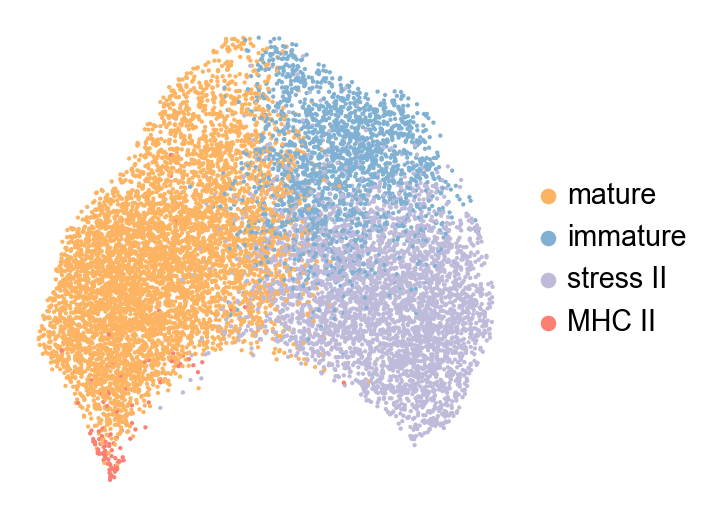

... storing 'project' as categorical
... storing 'sequencingInstrument' as categorical
... storing 'sequencingRun' as categorical
... storing 'sequencingDate' as categorical
... storing 'species' as categorical
... storing 'CellTypeEstimatePatching' as categorical
... storing 'SodiumChannelConductance_pS' as categorical
... storing 'SolutioninDish' as categorical
... storing 'gene_group_NUP93' as categorical
... storing 'preincubation' as categorical
... storing 'Patched' as categorical
... storing 'DonorID' as categorical
... storing 'Cryopreserved' as categorical
... storing 'DiabetesStatus' as categorical
... storing 'FACS sorted' as categorical
... storing 'Sex' as categorical
... storing 'Donation type' as categorical
... storing 'DNA content (ug):' as categorical
... storing '10 mM to 1 mM stimulation index' as categorical
... storing '16.7 mM to 1 mM stimulation index' as categorical
... storing '16.7 mM to 2.8 mM stimulation index' as categorical
... storing 'notes' as categori

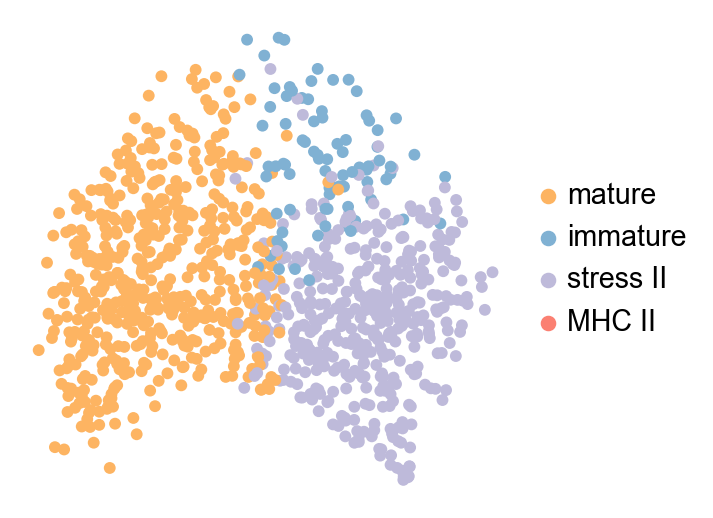

In [80]:
sc.pl.umap(adata_alpha_g_scaled, color='louvain_anno_fine', size=15, title='')
sc.pl.umap(adata_alpha_patch_g_scaled, color=['louvain_anno_fine'], title='')

In [81]:
adata_alpha_patch_g_scaled.obs.louvain_anno_fine.value_counts()

mature       544
stress II    431
immature      82
MHC II         0
Name: louvain_anno_fine, dtype: int64

In [82]:
pd.crosstab(adata_alpha_patch_g_scaled.obs.louvain_anno_fine, adata_alpha_patch_g_scaled.obs.DiabetesStatus, normalize=1)

DiabetesStatus,T2D,T2Dreversed,cryo_T1D,cryo_healthy,healthy,prediabetic
louvain_anno_fine,,,,,,
mature,0.445055,0.677419,0.696970,0.558824,0.456522,0.666667
immature,0.093407,0.139785,0.196970,0.014706,0.067029,0.010417
stress II,0.461538,0.182796,0.106061,0.426471,0.476449,0.322917


transfer labels to expression data

In [83]:
adata_alpha_patch = adata[adata.obs.cell_type.isin(['alpha'])].copy()
adata_alpha_patch.obs['louvain_anno_fine'] = adata_alpha_patch_g_scaled.obs['louvain_anno_fine']

subset to healhty cells

In [84]:
adata_alpha_patch = adata_alpha_patch[adata_alpha_patch.obs.DiabetesStatus.isin(['healthy', 'cryo_healthy'])].copy()

### Gene set activation

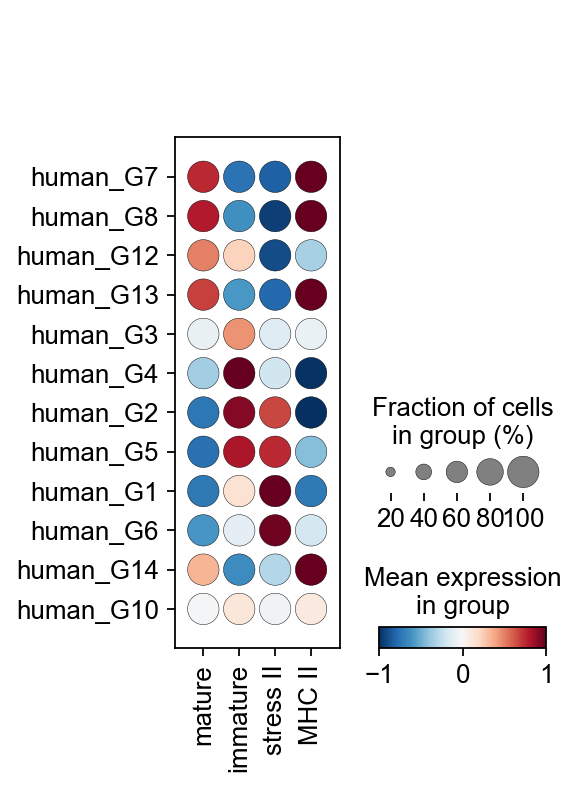

In [86]:
sc.pl.dotplot(adata_alpha_g_scaled, groupby='louvain_anno_fine', 
              var_names=adata_alpha_g.var_names, swap_axes=True,  
              expression_cutoff=-3, vmax=1, vmin=-1, cmap='RdBu_r')

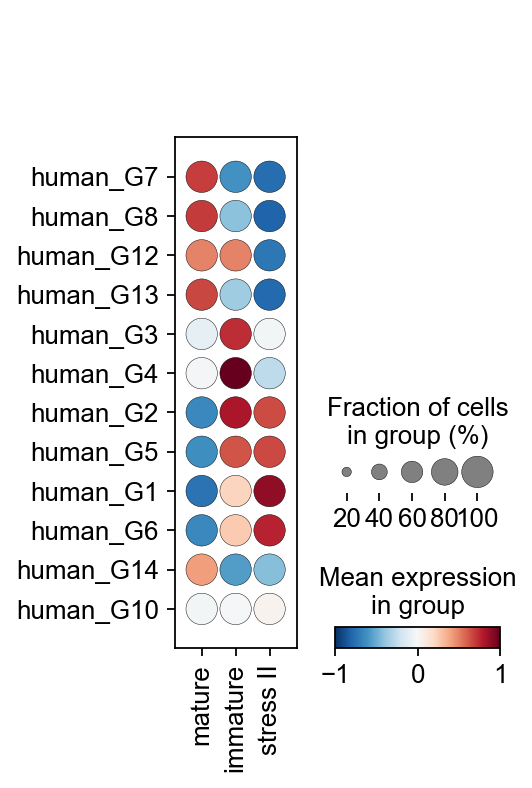

In [87]:
sc.pl.dotplot(adata_alpha_patch_g_scaled, groupby='louvain_anno_fine', 
              var_names=adata_alpha_g.var_names, swap_axes=True,  
              expression_cutoff=-3, vmax=1, vmin=-1, cmap='RdBu_r')

### Alpha cell state marker expression

In [88]:
gc_dict = {'endocrine identity/\nmaturation': ['FEV', 'NKX2-2', 'NEUROD1', 'ARX', 'ISL1', 'LOXL4', 'WNT4'],
            'developmental\nfactors': ['WNT2', 'SOX4', 'SOX11', 'NRG1', 'EPHB2',  'EPHB6', 'SPOCK1'],
            'TGFB\nsignaling': ['TGFBR1', 'TGFBR2', 'TGFB1', 'SMAD3', 'SMAD5', 'SMAD7', 'SMAD9', 'SOCS3', 
                    'ID1', 'ID2', 'ID3', 'TNC', 'MET', 'MYC', 'CDH6', 'BMP2', 'BMP8B', 'BMP5']}

In [89]:
genes = []
for k,v in gc_dict.items():
    genes = genes + v

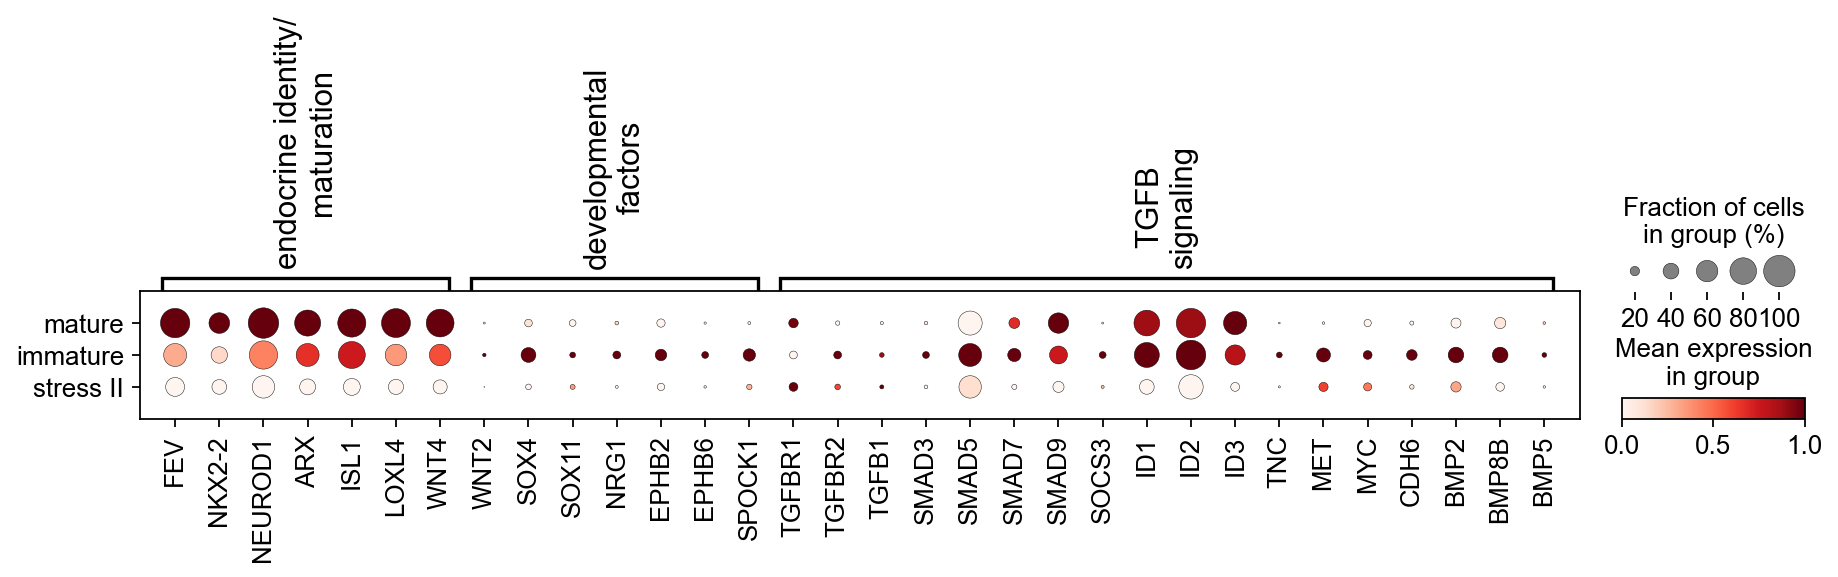

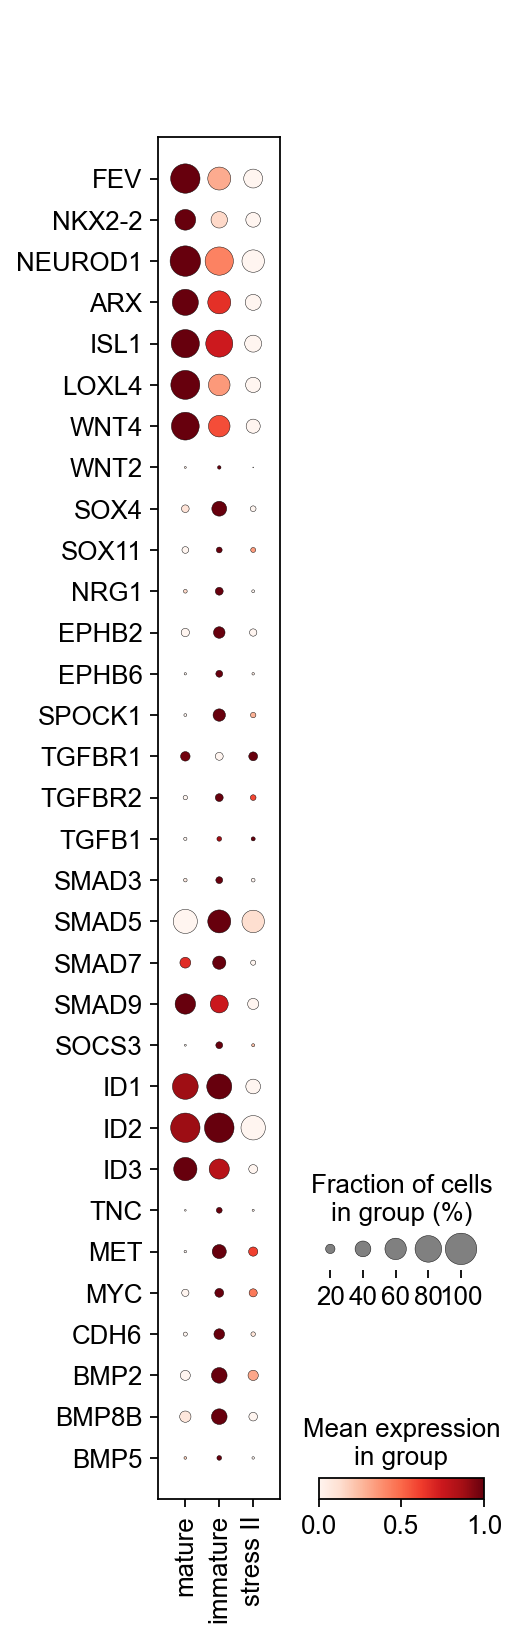

In [91]:
sc.pl.dotplot(adata_alpha_patch, var_names=gc_dict, 
              groupby='louvain_anno_fine', standard_scale='var')
sc.pl.dotplot(adata_alpha_patch, var_names=genes, swap_axes=True,
              groupby='louvain_anno_fine', standard_scale='var')

In [92]:
gc_dict = {'cell adhesion': ['ITGA2', 'ITGA6', 'ITGB6', 'LAMA3', 'LAMB3', 'LAMC1', 'LAMC2', 'FLRT2'],
           'cytokines': ['LIF', 'LIFR', 'TSLP', 'IL11', 'IL15', 'CXCL1', 'CXCL2'],
           'interferone response': ['IFIT3', 'IFI16', 'GBP1', 'GBP2', 'GBP3'],
           'other markers': ['SGK1', 'SHC4', 'PHLDA1', 'PHLDA2', 'LUCAT1']}

In [93]:
genes = []
for k,v in gc_dict.items():
    genes = genes + v

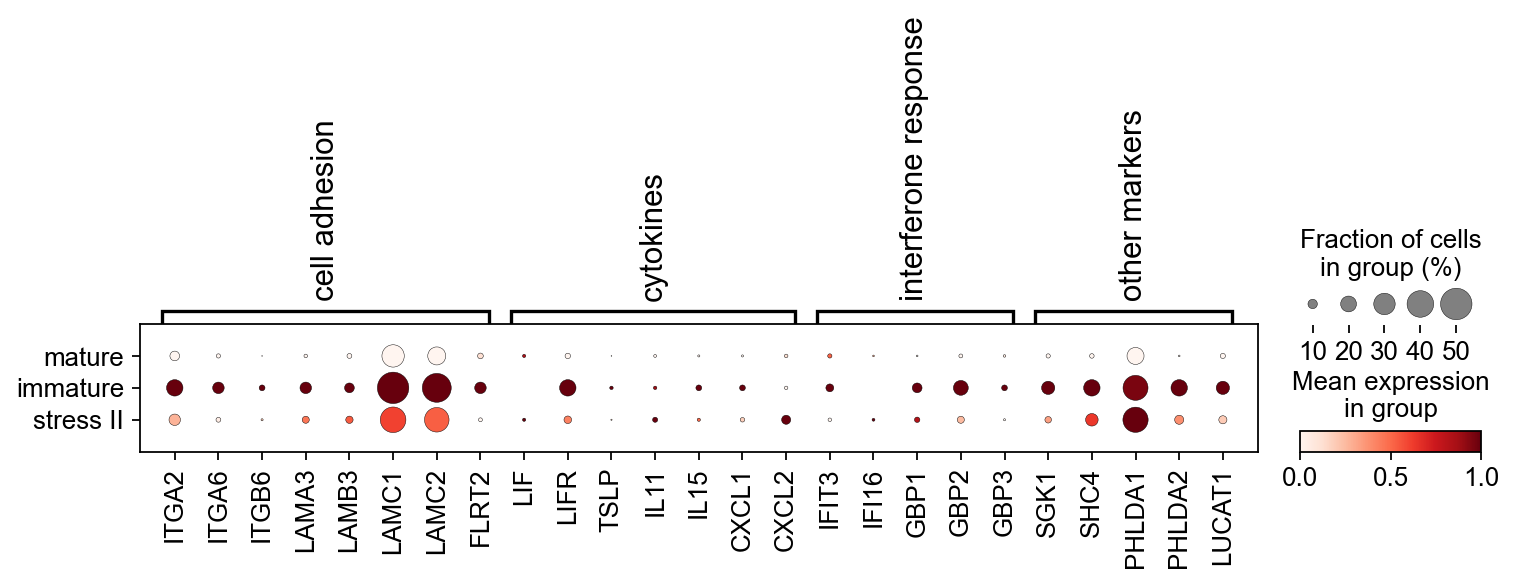

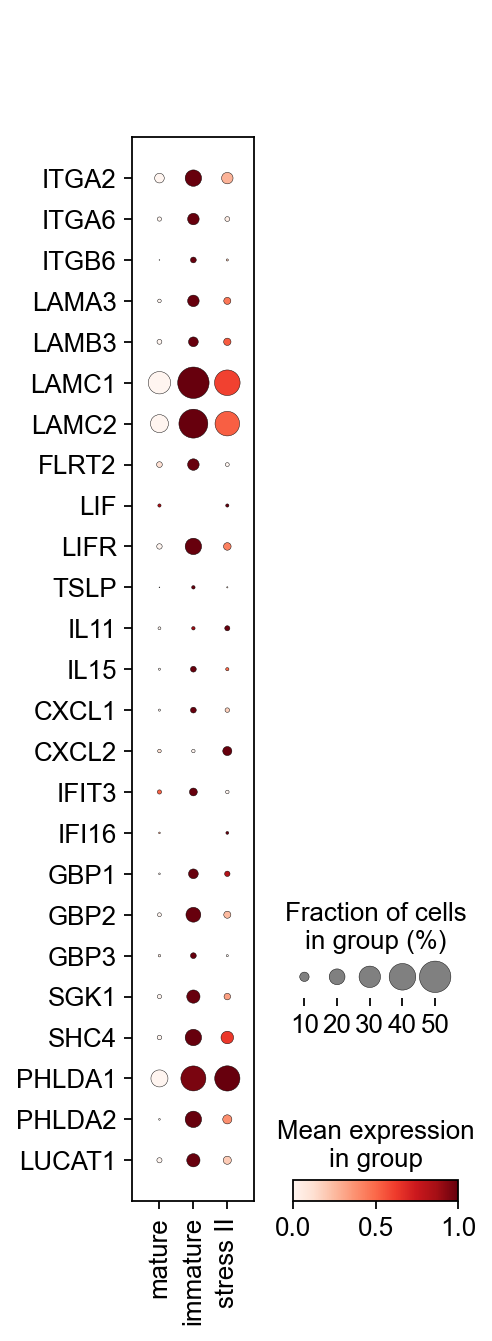

In [94]:
sc.pl.dotplot(adata_alpha_patch, var_names=gc_dict, 
              groupby='louvain_anno_fine', standard_scale='var')
sc.pl.dotplot(adata_alpha_patch, var_names=genes, swap_axes=True,
              groupby='louvain_anno_fine', standard_scale='var')

### Cell state distribution

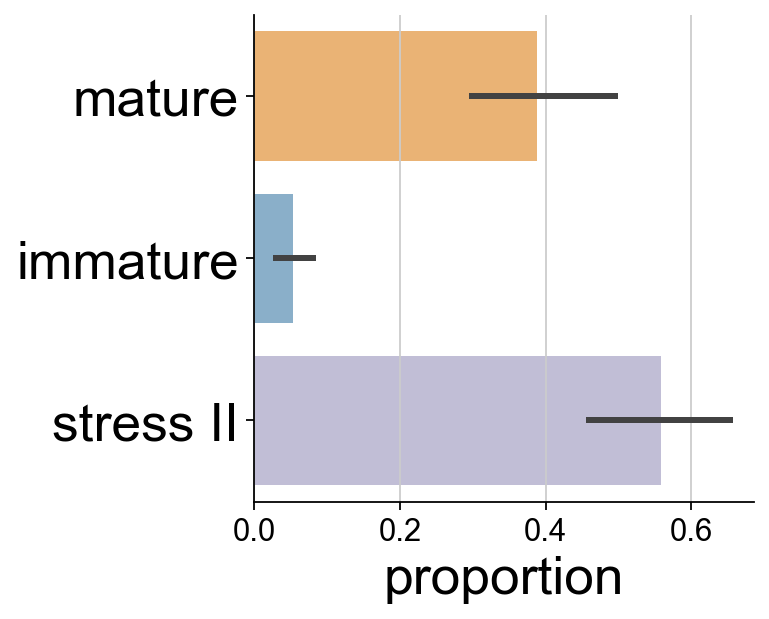

In [95]:
x1='louvain_anno_fine'
hue='DonorID'
y='proportion'
df = pd.crosstab(adata_alpha_patch.obs[x1], adata_alpha_patch.obs[hue], normalize=1)
df.index = df.index.tolist()
df.columns = df.columns.tolist()
prop_df = df.reset_index().melt(id_vars=['index'])
ax = sns.barplot(y='index', x='value', data=prop_df, palette=adata_alpha.uns['louvain_anno_fine_colors'], orient='h')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=24)
#ax.set_title('cell type distribution', fontsize=24)
ax.set_xlabel('proportion', fontsize=24)
ax.set_ylabel('')
    
sns.despine()

### Electrophysiology

In [96]:
ephys_dict= {'Size': ['Cell size'],
         'Exocytosis': ['Total exocytosis', 'Early exocytosis', 'Late exocytosis'],
         'Calcium channels': ['Ca2+ entry', 'Early Ca2+ current', 'Late Ca2+ current', 'Late Ca2+ Conductance'],
         'Sodium channels'  : ['Peak Na+ current', 'Na+ conductance']}
ephys_list = []
for key, par in ephys_dict.items():
    ephys_list = ephys_list + par

In [97]:
df_meta = adata_alpha_patch.obs[ephys_list].copy()

In [98]:
df_meta = df_meta.loc[adata_alpha_patch.obs.Patched=='Yes'].copy()

In [99]:
df_meta.dropna(axis=0, how='all', inplace=True)

In [100]:
qlow=0.03
qhigh=0.97
x = filter_quantile_values(df_meta, columns=ephys_list, qlow=qlow, qhigh=qhigh, include_quantiles=False)

In [101]:
df_meta.fillna(0, inplace=True)

In [102]:
x['cell_type'] = adata_alpha_patch.obs.loc[x.index, 'louvain_anno_fine']

In [103]:
x.cell_type.value_counts()

mature       237
stress II    194
immature      32
Name: cell_type, dtype: int64

In [104]:
for par in ephys_list:
    if x[par].mean() < 0:
        x[par] = -1*(x[par])
    #clip value of electrophysiology to zero, no negative values
    x[par] = x[par].clip(lower=0)


In [105]:
pvals = df_get_mu_pvals(x, pars=ephys_list[1:], categories=['mature', 'immature'])

In [106]:
pvals

,pval,FDR
Total exocytosis,0.406795,0.406981
Early exocytosis,0.272523,0.406981
Late exocytosis,0.337240,0.406981
Ca2+ entry,0.172451,0.388014
Early Ca2+ current,0.021246,0.095607
Late Ca2+ current,0.056446,0.169339
Late Ca2+ Conductance,0.406981,0.406981
Peak Na+ current,0.009108,0.081968
Na+ conductance,0.259399,0.406981


In [107]:
pvals_2 = df_get_mu_pvals(x, pars=ephys_list[1:], categories=['mature', 'stress II'])
pvals_2

,pval,FDR
Total exocytosis,0.019196,0.034553
Early exocytosis,0.007903,0.023708
Late exocytosis,0.014108,0.031743
Ca2+ entry,0.413932,0.413932
Early Ca2+ current,0.000049,0.000223
Late Ca2+ current,0.290908,0.338582
Late Ca2+ Conductance,0.284399,0.338582
Peak Na+ current,0.000023,0.000210
Na+ conductance,0.300962,0.338582


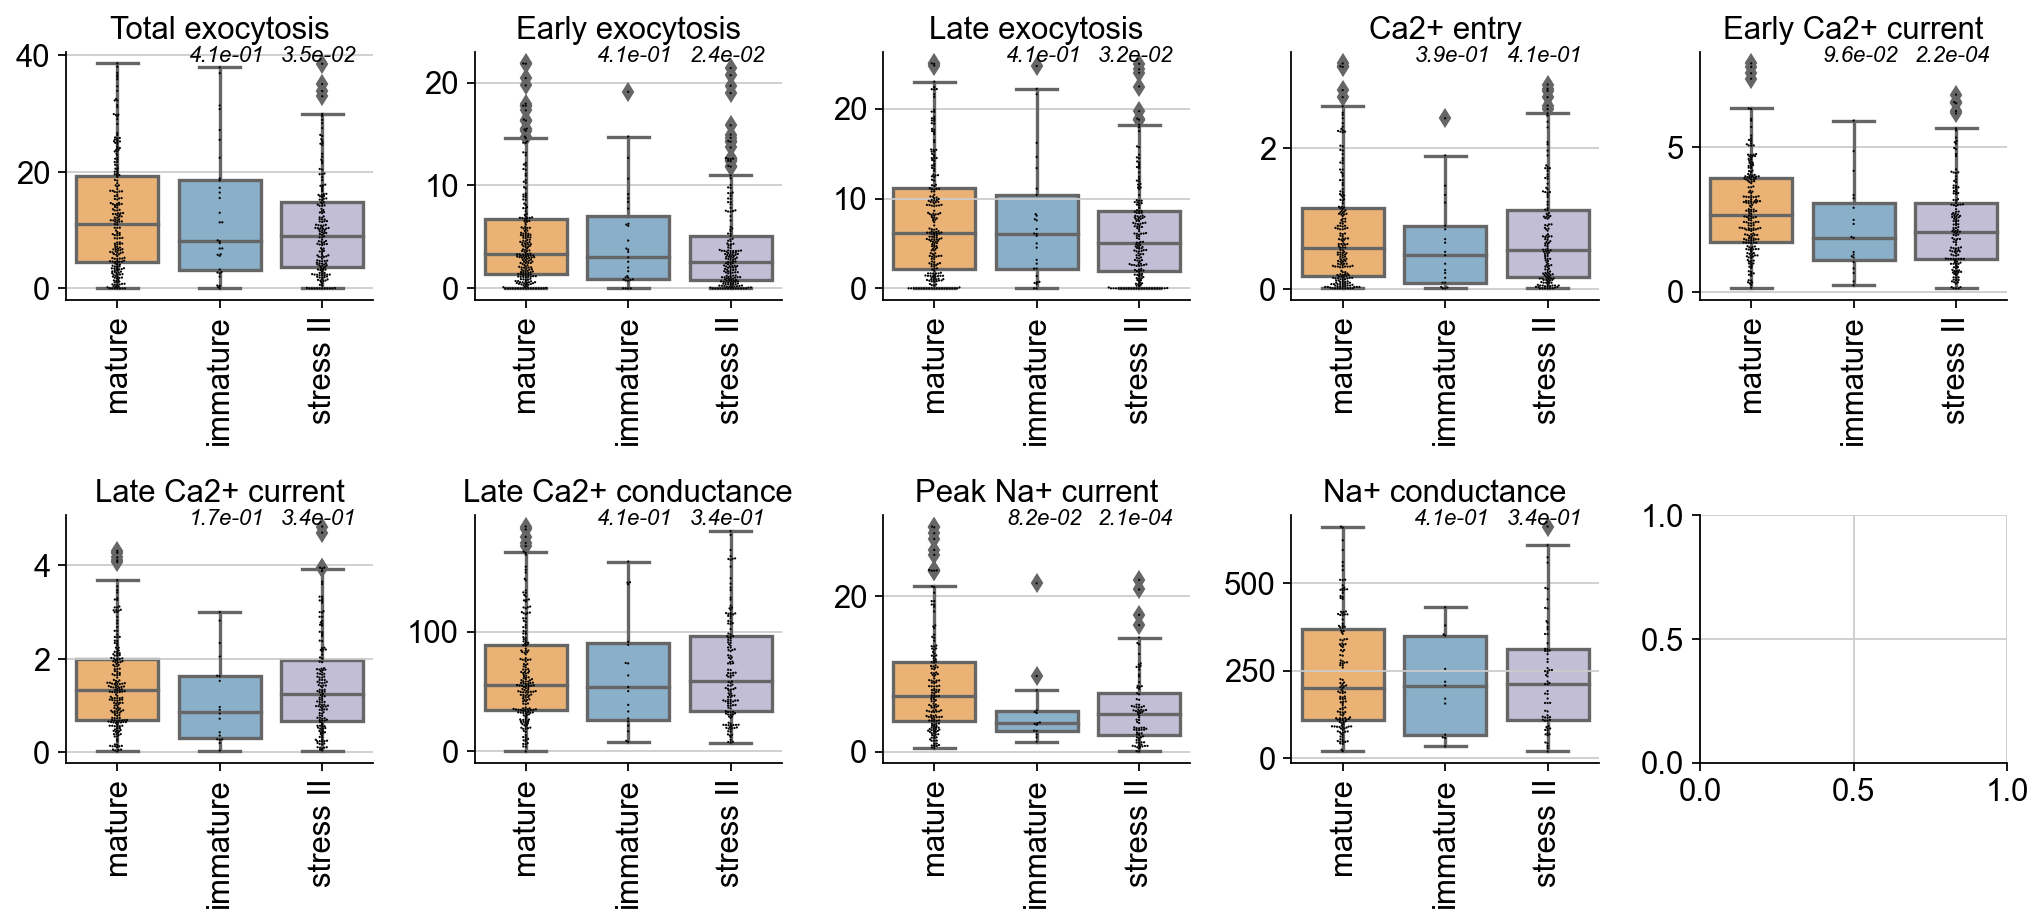

In [108]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(13,6))
axs = axs.flatten()

for i, key in enumerate(ephys_list[1:]):
    sns.boxplot(data=x, y=key, x='cell_type', ax=axs[i], palette=['#fdb462', '#80b1d3', '#bebada'])
    sns.swarmplot(data=x, y=key, x='cell_type', ax=axs[i], size=1, palette=['black'])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    #axs[i].text(0.5,0.96, r'$p_{{FDR}}=${:.1e}'.format(pvals.loc[key,'FDR']), style='italic',fontsize=10, transform = axs[i].transAxes)
    
    axs[i].text(0.4,0.96, r'{:.1e}'.format(pvals.loc[key,'FDR']), style='italic',fontsize=10, transform = axs[i].transAxes)
    axs[i].text(0.7,0.96, r'{:.1e}'.format(pvals_2.loc[key,'FDR']), style='italic',fontsize=10, transform = axs[i].transAxes)

    axs[i].set_title(key)
    if key =='Late Ca2+ Conductance':
        axs[i].set_title('Late Ca2+ conductance')

    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    
sns.despine()
plt.tight_layout()
plt.show()